<a href="https://colab.research.google.com/github/denniesbor/Module_3_Twist/blob/development/Knowledge_Graph_Queries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h2><strong>Dennies Bor</strong></h2></center>
<center><h2><strong>Module 3 Twist</strong></h2></center>

In [32]:
from datetime import date, timedelta
import matplotlib.pyplot as plot
import pandas as pd
import seaborn as sns
import collections
import re
import os
import seaborn
import tempfile
import warnings
warnings.filterwarnings('ignore')

# **Query the knowledge graph**
Use bigquery in kaggle to extract the knowledge graph dataset. Since this will query huge amount of data, we restrict ourselves to Kenya and a time frame of one week.

In [4]:
from google.cloud import bigquery
client = bigquery.Client()
dataset_ref = client.dataset("gdeltv2", project="gdelt-bq")
dataset = client.get_dataset(dataset_ref)
tables = list(client.list_tables(dataset))

**Query**

In [ ]:
query = """
        SELECT DISTINCT *
        FROM (
          SELECT
            EXTRACT (date
            FROM
              PARSE_TIMESTAMP('%Y%m%d%H%M%S',CAST(date AS string))) AS Date,
              
            GKGRECORDID AS ID,
            SourceCommonName AS Source,
            Counts,
            V2Counts,
            
            DocumentIdentifier AS Link,

            Themes AS Themes,
            
            
            Locations AS Locations,
            Extras,

            CAST(SPLIT(V2Tone, ",") [
            OFFSET
              (0)] AS FLOAT64) AS Sentiment,
            CAST(SPLIT(V2Tone, ",") [
            OFFSET
              (3)] AS FLOAT64) AS Polarity,
            CAST(SPLIT(V2Tone, ",") [
            OFFSET
              (4)] AS FLOAT64) AS ARF,
            
          FROM
            `gdelt-bq.gdeltv2.gkg` )
        WHERE
          Locations LcleaningIKE '%#KE#%'
            AND Date >= "2022-04-11"
        """

In [ ]:
# save the queried data

query_job = client.query(query)
events = query_job.to_dataframe()
events
events.to_csv("Kenya1.csv")

# Location type exploding and filtering of the Downloaded Dataset

In [3]:
from enum import Enum

class location_type(Enum):
    """Location type
        Defines the different location types.
    """
    UNKNOWN = 0
    COUNTRY = 1
    USSTATE = 2
    USCITY = 3
    WORLDCITY = 4
    WORLDSTATE = 5

class gdelt_location:
    """GDELT location
        Defines a GDELT location.
    """
    def __init__(self, location_typeid=0, name=None, country_code=None, admin1_code=None, lat=None, lon=None, feature_id=None):        
        self.location_type = location_type(int(location_typeid))
        self.location_name = name
        self.country_code = country_code
        self.admin1_code = admin1_code
        self.location_lat = lat
        self.location_lon = lon
        self.feature_id = feature_id
        
    def has_location_type(self, location_type):
        return location_type == self.location_type
    
    def location_type_matches(self, location_types):
        return self.location_type in location_types
    
    def __str__(self):
        return self.location_name
    
class location_filter():
    """Location Filter
        Defines different filters which can be applied on the dataframes.
    """
    def filter_by_type(self, gkg_dataframe, location_type):
        return gkg_dataframe.loc[gkg_dataframe.apply(lambda record: record["GDELT_Locations"].has_location_type(location_type), axis=1)]
    
    def filter_by_types(self, gkg_dataframe, location_types):
        return gkg_dataframe.loc[gkg_dataframe.apply(lambda record: record["GDELT_Locations"].location_type_matches(location_types), axis=1)]

def split_location_entries(locations):
    return [gdelt_location(*location) if 7 == len(location) else gdelt_location() for location in locations]

def split_locations(record):
    return split_location_entries([location.split("#") for location in str(record["Locations"]).split(";")])


# Filter the locations by location type & Extract the coordinates and the name from the GDELT location
- We are exploding the records using the locations column
- We are filtering by using the location type (e.g. return only cities)

In [4]:
df = pd.read_csv(f"/content/drive/MyDrive/Module3/twist/Kenya1.csv")
df_records = df[df['Locations'].str.contains(r'Kenya|#KE#', flags=re.IGNORECASE, regex=True, na=False)]
# df_records['Sentiment'] = df_records['V2Tone'].apply(lambda x: float(x.split(',')[0])).round(decimals=2)
# df_records['Polarity'] = df_records['V2Tone'].apply(lambda x: float(x.split(',')[3])).round(decimals=2)

df_locations = df_records.copy(deep=True)
if df_locations.empty:
    df_locations["GDELT_Locations"] = []
    df_filtered_locations = df_locations
else:
    df_locations["GDELT_Locations"] = df_records.apply(lambda record: split_locations(record), axis=1)
    df_locations_exploded = df_locations.explode("GDELT_Locations")

    filter = location_filter()
    df_filtered_locations = filter.filter_by_types(df_locations_exploded, [location_type.WORLDCITY, location_type.USCITY])
df_filtered_locations["Location_Name"] = df_filtered_locations.apply(lambda record: record["GDELT_Locations"].location_name, axis=1)
df_filtered_locations["Location_Lat"] = df_filtered_locations.apply(lambda record: record["GDELT_Locations"].location_lat, axis=1)
df_filtered_locations["Location_Lon"] = df_filtered_locations.apply(lambda record: record["GDELT_Locations"].location_lon, axis=1)
df_filtered_locations["Year"] = df_filtered_locations["ID"].apply(lambda record: record[:4])
df_filtered_locations["Month"] = df_filtered_locations["ID"].apply(lambda record: record[4:6])
df_filtered_locations = df_filtered_locations[df_filtered_locations['Location_Name'].str.contains(r'Kenya', flags=re.IGNORECASE, regex=True, na=False)]
# print(df_filtered_locations.iloc[0]["Location_Name"])
point_locations = df_filtered_locations[["ID", "Date","Year","Month","Source","Link",\
                                          "Sentiment", "Polarity","Extras","Location_Name","Location_Lat","Location_Lon",
                                          "Themes"]].copy(deep=True)

del df_locations_exploded
del df_locations
del df_records
del df
del df_filtered_locations

# del graph

In [5]:
df_final = point_locations.copy(deep=True)
# save the dfs
df_final[["ID", "Date","Year","Month","Source","Link",\
          "Sentiment", "Polarity","Extras","Location_Name",\
          "Location_Lat","Location_Lon","Themes"]].to_csv('/content/drive/MyDrive/Module3/twist/final_bigquery_.csv', index=False)

df = df_final.copy(deep=True)

# drop duplicates based on ID
df.drop_duplicates(subset=["ID"],inplace=True)

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Module3/twist/final_bigquery_.csv')

In [5]:
df.shape

(4169, 13)

**Helper Functions**

In [6]:
def split_doc_identifier(text):
  """This function will split the header and extract the title
  """
  texts = text.split('/')
  return [' '. join(text.split('-')) for text in texts if '-' in text]

def split_extras(text):
  '''The function will return page title in the article metadata
  '''
  title = text.split('<PAGE_TITLE>')[1].split('<')[0]
  return title

def split_themes(text):
  '''This function cleans the themes text and return array of themes in the article
  '''
  try:
    themes = list(set([theme.split(',')[0] for theme in text.split(';') if theme !='']))
  except:
    themes = text
  return themes


**Apply Helper Functions**

In [7]:
df['TitleTokens'] = df['Link'].apply(split_doc_identifier)
df['Title'] = df['Extras'].apply(split_extras)
df['Themes_Compute'] = df['Themes'].apply(split_themes)

# drop nans, similar titles and reset index
df.dropna(inplace=True)
df.drop_duplicates(subset=["Title"],inplace=True)
df.reset_index(inplace=True, drop=True)

In [8]:
df.head()

,ID,Date,Year,Month,Source,Link,Sentiment,Polarity,Extras,Location_Name,Location_Lat,Location_Lon,Themes,TitleTokens,Title,Themes_Compute
0,20220412104500-162,2022-04-12,2022,4,dallassun.com,https://www.dallassun.com/news/272473674/ident...,3.053435,4.274809,<PAGE_LINKS>https://pr.report/45BqXECG;https:/...,"Nairobi, Nairobi Area, Kenya",-1.283330,36.8167,CRISISLEX_C07_SAFETY;UNGP_FORESTS_RIVERS_OCEAN...,[idently systems limited joins globalsigns cer...,Idently Systems Limited Joins GlobalSign's Cer...,"[GENERAL_GOVERNMENT, TAX_MILITARY_TITLE, TAX_F..."
1,20220412104500-T122,2022-04-12,2022,4,tolerance.ca,https://www.tolerance.ca/ArticleExt.aspx?ID=50...,-3.488372,15.116279,<PAGE_TITLE>Tolerance.ca&#xAE; - R&#xE9;publiq...,"Nairobi, Nairobi Area, Kenya",-1.283330,36.8167,GENERAL_GOVERNMENT;TAX_FNCACT;TAX_FNCACT_CRIMI...,[],Tolerance.ca&#xAE; - R&#xE9;publique centrafri...,"[TAX_WORLDFISH_BASS, GENERAL_GOVERNMENT, WB_84..."
2,20220412180000-511,2022-04-12,2022,4,president.go.ke,https://www.president.go.ke/2022/04/12/first-l...,4.160247,12.480740,<PAGE_TITLE>First Lady Margaret Kenyatta ralli...,"Kiambu, Central, Kenya",-1.166670,36.8333,TAX_FNCACT;TAX_FNCACT_LADY;GENERAL_HEALTH;MEDI...,[first lady margaret kenyatta rallies health s...,First Lady Margaret Kenyatta rallies health st...,"[TAX_AIDGROUPS, TAX_WORLDMAMMALS, GENERAL_GOVE..."
3,20220415084500-710,2022-04-15,2022,4,msn.com,https://www.msn.com/en-xl/africa/kenya/land-ro...,-1.081081,2.702703,<PAGE_TITLE>Land row derails building of key K...,"Nzoia, Kenya (General), Kenya",0.057004,33.9528,GENERAL_GOVERNMENT;EPU_POLICY;EPU_POLICY_GOVER...,"[en xl, land row derails building of key kenya...",Land row derails building of key Kenya-Uganda ...,"[GENERAL_GOVERNMENT, WB_2576_REGIONAL_INTEGRAT..."
4,20220412130000-T428,2022-04-12,2022,4,orf.at,https://orf.at/stories/3259426/,-11.445783,12.650602,<PAGE_PRECISEPUBTIMESTAMP>20220412000000</PAGE...,"Nairobi, Nairobi Area, Kenya",-1.283330,36.8167,FOOD_SECURITY;NATURAL_DISASTER;NATURAL_DISASTE...,[],Millionen Menschen in Somalia droht Hungerkata...,"[TAX_AIDGROUPS, NATURAL_DISASTER_DROUGHT, GENE..."


## **Natural Language Processing**
We have extracted article titles from the gdelt raw data. We have filtered the data to Kenya alone in a period of one week. The next tasks is to identify some of the common topics from the articles.


In [9]:
import datetime
import time
import tweepy
import pandas as pd
import numpy as np
import nltk
import spacy
import re

import matplotlib.pyplot as plt

from wordcloud import WordCloud
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
tokenizer = ToktokTokenizer()
from nltk.corpus import stopwords
nltk.download("stopwords")
nlp = spacy.load('en_core_web_sm')
from collections import Counter
%matplotlib inline

# stopwords
stopwrds = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### **Text Cleaning**
Perform tokenization, lemmatization, and removal of stop words

In [11]:
# Text cleaning
def clean_text(text):
    
    """
    A function to clean the text
    """
    #Remove hyper links
    text = re.sub(r'&amp;','&',text)
    text = re.sub(r'https?:\/\/\S+', ' ', text)
    
    #Remove @mentions
    text = re.sub(r'@[A-Za-z0-9]+', ' ', text)
    text = re.sub(r'# justiceforkianjokomabrother| # justiceforemmanuelandbenson', ' ',text)
    
    #Remove anything that isn't a letter, number, or one of the punctuation marks listed
    text = re.sub(r"[^A-Za-z0-9]+", ' ', text)
    
    #Create NLP Document
    doc = nlp(text)
    
    # Tokenize the text and remove stopwords
    tokens = [word for word in [str(token.lemma_).strip() for token in doc] 
              if word != '-PRON-' and word not in stopwrds]
    
    filtered_text = ' '.join(tokens)  
    
    return filtered_text.lower()

#  clean the title texts in the dataframe
df['Clean_Title'] = df['Title'].apply(clean_text)

#### **Language detection**

Some articles are written in French, Swahili, and Kenya's native languages. We remove these articles and use English.

In [12]:
!pip install langdetect

     |████████████████████████████████| 981 kB 5.4 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=77f8cad0918da752c52826709285820446bd5b578331cf3bb7074bd90f7a8680
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [13]:
from langdetect import detect

def detect_lang(text):
  """ The functions detects the language in a text
  """
  try:
    lang = detect(text)
  except:
    print(text)
    lang = None
  return lang

In [14]:
# detect languages
df['Lang'] = df.Title.apply(detect_lang)

In [15]:
df['Lang'].unique()

array(['en', 'fr', 'de', None, 'sw', 'pt', 'so', 'no', 'tl', 'nl', 'es',
       'ca', 'id', 'it', 'af', 'pl', 'et', 'fi', 'ro', 'sv', 'lt', 'da',
       'hu', 'sk'], dtype=object)

In [16]:
# extract languages in english only
df = df[(df['Link'].str.contains(r'standardmedia.co.ke|apnews|theafricareport|capitalfm.co.ke', regex=True, flags=re.IGNORECASE)) | (df['Lang']=='en')]
df.reset_index(inplace=True, drop=True)

**Visualize the common words in a word cloud**

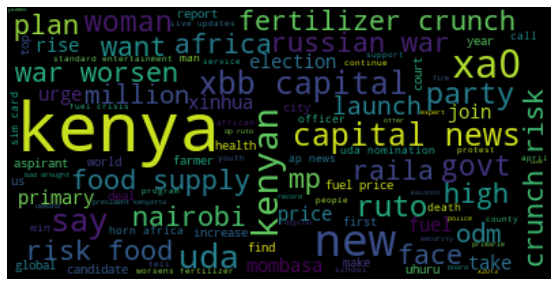

In [25]:
# plot the wordcloud of the titles
words = ' '.join([text for text in df['Clean_Title']])
clean_words = []
for word in words.split():
    if word not in stopwrds:
        clean_words.append(word)
word_cloud = WordCloud(max_font_size = 50,background_color='black',max_words=100).generate(' '.join(clean_words))

plt.figure(figsize = (10,5))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [18]:
# plot the sentiments of the titles

positive = df[df['Sentiment'] > 0]
negative = df[df['Sentiment'] < 0]
neutral = df[df['Sentiment'] == 0]

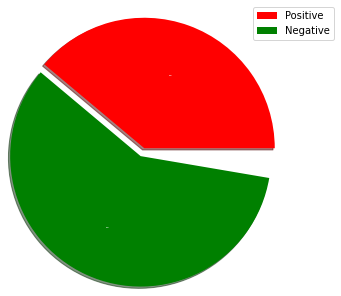

In [19]:
# visualize sentiment distribution in pyplot
colors = ['red','green']
sizes = [positive.shape[0]/df.shape[0],negative.shape[0]/df.shape[0]]
explode = [0,0.1]
labels = ['Positive','Negative']
plt.pie(x=sizes,labels=labels,explode=explode,colors=colors,shadow=True,radius=1.5,\
        center=(-0.5,1),autopct='%1.1f%%',textprops={'fontsize': 1,'color':'white','weight':'bold'})
plt.legend(loc=(1,1))
plt.show()

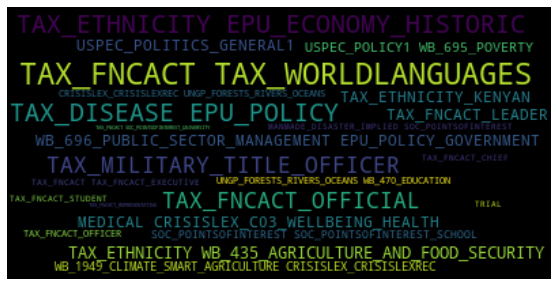

In [30]:
# visualize the most common themes

themes = []
for theme in df['Themes_Compute']:
  themes+=theme

word_cloud = WordCloud(max_font_size = 50,background_color='black',max_words=100).generate(' '.join(themes))

plt.figure(figsize = (10,5))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

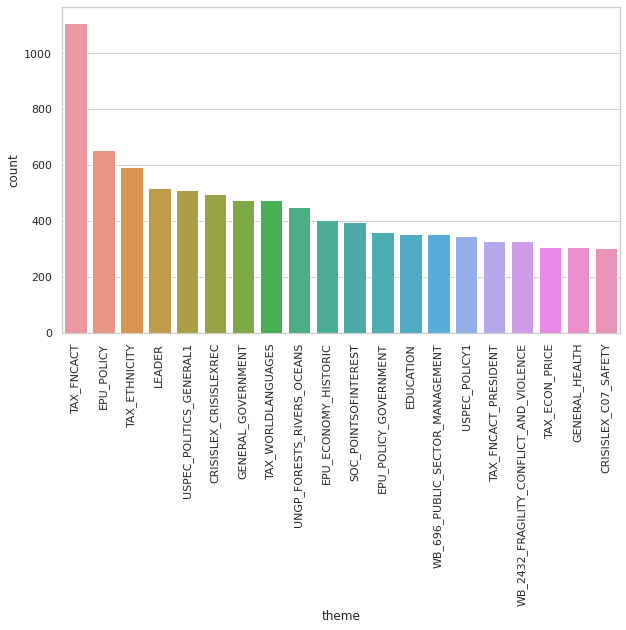

In [76]:
# plot as a distribution plot of the most common

df_common_themes = pd.DataFrame(themes, columns=['theme'])
theme_count = df_common_themes.theme.value_counts().reset_index().rename(columns={'index':"theme",'theme':'count'})
fig = plt.figure(figsize=(10,6))
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="theme", y="count", data=theme_count[:20])

plt.xticks(rotation=90)

#### **Topic Modelling**


The wordcloud and the bar plot above indicate the most frequent themes in the dataset. However, these are general topics and are difficult to know exactly what they are. In the next section, we are performing topic modelling of the title to extract specific key words.

In [27]:
!pip install bertopic[gensim]

     |████████████████████████████████| 57 kB 5.1 MB/s 
     |████████████████████████████████| 88 kB 8.4 MB/s 
     |████████████████████████████████| 5.2 MB 66.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 79 kB 11.3 MB/s 
     |████████████████████████████████| 4.0 MB 55.8 MB/s 
     |████████████████████████████████| 1.2 MB 56.7 MB/s 
     |████████████████████████████████| 77 kB 9.5 MB/s 
     |████████████████████████████████| 636 kB 70.3 MB/s 
     |████████████████████████████████| 6.6 MB 58.4 MB/s 
     |████████████████████████████████| 895 kB 67.1 MB/s 
     |████████████████████████████████| 1.1 MB 55.0 MB/s 
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp37-cp37m-linux_x86_64.whl size=2330755 sha256=1c72f0b6bc9bcb6f7079f41f3a045c4e5f791fd89ab3ad4c320ea672143dd4c3
  Stored in directory: /root/.cache/pip/wheels/6e/7a/5e/259ccc841c085fc41b99e

In [28]:
from bertopic import BERTopic


timestamps = df.Date.to_list()
words = df.Clean_Title.to_list()

topic_model = BERTopic(verbose=True)
topics, probs = topic_model.fit_transform(words)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Batches:   0%|          | 0/38 [00:00<?, ?it/s]

2022-04-17 23:28:41,734 - BERTopic - Transformed documents to Embeddings
2022-04-17 23:28:53,224 - BERTopic - Reduced dimensionality with UMAP
2022-04-17 23:28:53,276 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [29]:
topic_model.visualize_topics()

In [30]:
topic_model.visualize_barchart()

#### **Topics in the Past Week**

In [31]:
topics_over_time = topic_model.topics_over_time(words, topics, timestamps, nr_bins=20)
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10)

7it [00:00, 32.48it/s]
